In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(15,5)
pd.set_option('display.max_columns', 100)

import nltk
from scipy import stats
import re
from  scipy.stats import ttest_ind
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator,TransformerMixin

**Read the data and split into training and test datasets. We will be using the training part to further split into training and validation part. Once we find a good model we will test it's performance on unseen data (test dataset)**

In [2]:
data=pd.read_csv('Data/cleanedData.csv')
data.dropna(subset=['CleanWordList'],inplace=True)


cols=['COMMENT_ID','%OfUpperCaseLetters', 'NoOfURL', 'AvgLengthOfEachWord',
       '%OfNoOfStopWords', 'NoOfWords', '%OfNoOfUniqueWords',
       'AvgSentenceLength', 'TextStandard', 'CleanWordList']

X=data.loc[:,cols]
y=data['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y,random_state=147)

In [3]:
print('X_train, X_test, y_train, y_test: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test, y_train, y_test:  (1334, 10) (572, 10) (1334,) (572,)


**Vectorize the comments. Convert the term document matrix into pandas dataframe and then add other generated features to this dataframe.**

In [4]:
# countVectorizer=CountVectorizer(min_df=5,ngram_range=(1,3))

# X_train_dtm = countVectorizer.fit_transform(X_train['CleanWordList']) 
# X_test_dtm  = countVectorizer.transform(X_test['CleanWordList'])

# # Set features as column name
# colName=countVectorizer.get_feature_names()

# # Convert the document-term-matrix to a pandas dataframe
# X_train_df=pd.DataFrame(X_train_dtm.toarray(),columns=colName)
# X_test_df=pd.DataFrame(X_test_dtm.toarray(),columns=colName)

# # Add rest of the generates features to the dataframe
# X_train_all=pd.concat([X_train_df.reset_index(drop=True),
#                       X_train.drop(columns=['COMMENT_ID','CleanWordList']).reset_index(drop=True)],
#                      axis=1,ignore_index=False)

# X_test_all=pd.concat([X_test_df.reset_index(drop=True),
#                      X_test.drop(columns=['COMMENT_ID','CleanWordList']).reset_index(drop=True)],
#                     axis=1,ignore_index=False)

**Compare CountVectorizer and TfidfVectorizer by passing the document-term-matrix from the two vectorizers through MultinomialNB()**

In [13]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=LogisticRegression(),):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        Default estimator: LogisticRegression()
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    

In [18]:
class Transfomer(BaseEstimator, TransformerMixin):
    
    def __init__(self,vectorizer=CountVectorizer()):
        self.vectorizer=vectorizer
        self.X=X

    def fit(self, X, y=None):
        """
        Learn how to transform data based on input data, X.
        """
        return self.vectorizer.fit(X)

    def transform(self, X):
        """
        Transform X into a new dataset, Xprime and return it.
        """
        return self.vectorizer.transform(X).toarray()

In [39]:
pipe_CompareVectorizer= Pipeline([('vectorizer',Transfomer()),
                                  ('clf', ClfSwitcher())
                                ])
paramGrid_CompareVectorizer=[ {
                            'vectorizer__vectorizer':[TfidfVectorizer()],
                            'vectorizer__vectorizer__min_df':[0.1,0.01,0.001,0.0001],
                            'vectorizer__vectorizer__ngram_range':[(1,2),(1,3)],
                            'clf__estimator':[MultinomialNB()]
                              },
                              {
                            'vectorizer__vectorizer':[CountVectorizer()],
                            'vectorizer__vectorizer__min_df':[0.1,0.01,0.001,0.0001],
                            'vectorizer__vectorizer__ngram_range':[(1,2),(1,3)],
                            'clf__estimator':[MultinomialNB()]
                              }
                            ]

In [40]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Gridsearch with count vectorizer and TFIDF
gs_CompareVectorizer = GridSearchCV(pipe_CompareVectorizer, param_grid=paramGrid_CompareVectorizer,n_jobs=-1,
                                    cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_CompareVectorizer.fit(X_train['CleanWordList'],y_train);


gs_CompareVectorizer.best_params_['vectorizer__vectorizer']

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0001,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [51]:
gs_CompareVectorizer.cv_results_['mean_train_score']

array([0.80556022, 0.80556022, 0.9579774 , 0.95700939, 0.98571805,
       0.98576662, 0.99694059, 0.9978744 , 0.81664094, 0.81664094,
       0.95227351, 0.95025845, 0.97603559, 0.97266287, 0.99584346,
       0.99748621])

In [102]:
# (gs_CompareVectorizer.cv_results_['params'])


In [105]:
temp=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'],
                  gs_CompareVectorizer.cv_results_['mean_train_score']).reset_index()
temp['clf__estimator']=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'])['clf__estimator'].apply(lambda x: str(x).split('(')[0])
temp['vectorizer__vectorizer']=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'])['vectorizer__vectorizer'].apply(lambda x: str(x).split('(')[0])

In [106]:
temp.rename(columns={'index':'ROC_AUC_SCORE',
                    'clf__estimator':'Estimator',
                    'vectorizer__vectorizer':'Vectorizer',
                    'vectorizer__vectorizer__min_df':'min_df',
                    'vectorizer__vectorizer__ngram_range':'ngram_range'},inplace=True)
temp.sort_values(by=['ROC_AUC_SCORE'],ascending=False,inplace=True)
temp.reset_index(inplace=True,drop=True)
temp

,ROC_AUC_SCORE,Estimator,Vectorizer,min_df,ngram_range
0,0.997874,MultinomialNB,TfidfVectorizer,0.0001,"(1, 3)"
1,0.997486,MultinomialNB,CountVectorizer,0.0001,"(1, 3)"
2,0.996941,MultinomialNB,TfidfVectorizer,0.0001,"(1, 2)"
3,0.995843,MultinomialNB,CountVectorizer,0.0001,"(1, 2)"
4,0.985767,MultinomialNB,TfidfVectorizer,0.0010,"(1, 3)"
5,0.985718,MultinomialNB,TfidfVectorizer,0.0010,"(1, 2)"
6,0.976036,MultinomialNB,CountVectorizer,0.0010,"(1, 2)"
7,0.972663,MultinomialNB,CountVectorizer,0.0010,"(1, 3)"
8,0.957977,MultinomialNB,TfidfVectorizer,0.0100,"(1, 2)"
9,0.957009,MultinomialNB,TfidfVectorizer,0.0100,"(1, 3)"


In [62]:
gs_CompareVectorizer.best_score_

0.9629218191240957

**Create a switcher function to call for different estimators to test**

Reference: https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers

**Create pipeline, initialize Kfold and then perform grid search to find best estimator and best parameters.**

In [315]:
pipeCV = Pipeline([
                    ('vectorizer',CountVectorizer(min_df=5,ngram_range=(1,3))),
                    ('clf', ClfSwitcher())
                    ])

pipeTFIDF = Pipeline([
                    ('vectorizer',TfidfVectorizer(min_df=5,ngram_range=(1,3))),
                    ('clf', ClfSwitcher())
                    ])


parameters =[
#             {'vectorizer__vectorizer':[CountVectorizer(min_df=5)],
#              'vectorizer__X':[X_train],
#             'vectorizer__vectorizer__ngram_range':[(1,3),(1,4)]
#             },
            {'clf__estimator':[MultinomialNB()]},
    
            {'clf__estimator': [LogisticRegression()],
#              'clf__estimator__C':[0.001,0.1,0.5,1,2,5,10,100,500,1000]
             'clf__estimator__C':[0.001]
            },

            {
            'clf__estimator':[RandomForestClassifier()],
            'clf__estimator__n_estimators':[30,70],
#             'clf__estimator__max_depth':[5,10,20,50,75,100,125,150,300,500,1000]
            },
    
            {
            'clf__estimator':[XGBClassifier()],
#             'clf__estimator__n_estimators':[5,10,30,50,75,100,125,150,200],
#             'clf__estimator__max_depth':[5,10,20,50,75,100,125,150,300,500,1000]
            }
            ]

# Initialize Kflod for cross validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Gridsearch with count vectorizer and TFIDF
gs_CV = GridSearchCV(pipeCV, parameters,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_TFIDF = GridSearchCV(pipeTFIDF, parameters,n_jobs=-1, cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

**Find the best estimator and best parameters for all of the data (vectorized text + engineered Features)**

In [316]:
gs_CV.fit(X_train['CleanWordList'],y_train);
gs_TFIDF.fit(X_train['CleanWordList'],y_train);



column={'Best ROC_AUC Score with CountVectorizer':[gs_CV.best_score_],
     'Test score-CV':[gs_CV.score(X_test['CleanWordList'],y_test)],
     'Best ROC_AUC Score with TFIDF':[gs_TFIDF.best_score_],
     'Test score-TFIDF':[gs_TFIDF.score(X_test['CleanWordList'],y_test)],}

pd.DataFrame(column)

,Best ROC_AUC Score with CountVectorizer,Test score-CV,Best ROC_AUC Score with TFIDF,Test score-TFIDF
0,0.966409,0.973425,0.966417,0.978297


In [338]:
def create_document_term_matrix(X,vectorizer=CountVectorizer()):
    """
    This function take in a dataframe with 'CleanWordList' column. 
    This column has preprocessed text that needs to be vectorized
    
    It return 2 dataframes. First dataframe is a vector representation of text field and 
    the second dataframe has other engineered feature along with vectorized text
    """
    document_term_matrix = vectorizer.fit_transform(X['CleanWordList']) 
    colName=vectorizer.get_feature_names()
    
    X_dtm_df=pd.DataFrame(document_term_matrix.toarray(),columns=colName)
    X_dtm_all=pd.concat([X_dtm_df.reset_index(drop=True),
                      X.drop(columns=['COMMENT_ID','CleanWordList']).reset_index(drop=True)],
                     axis=1,ignore_index=False)


    return X_dtm_df,X_dtm_all


In [345]:
def featureImportance(gs,X,y,engineeredFeatures=False,noOfFeatures=5):
    """
    Important features using Random Forest's feature_importances_ parameter.
    Set engineeredFeatured to True to include engineered features in calculation
    """
    
    X1,X2=create_document_term_matrix(X,gs_CV.estimator.named_steps['vectorizer'])
    
    if engineeredFeatures==True:
        X=X2
    else:
        X=X1
    
    #Random Forest is at 2 index in parameters list
    clf_rfc=gs.param_grid[2]['clf__estimator'][0].fit(X,y)

    impFeatures=clf_rfc.feature_importances_

    featureImportance=pd.DataFrame({'Feature Name':X.columns,
                                    'Importance':impFeatures})
    
    featureImportance.sort_values(by='Importance',ascending=False,inplace=True)
    
    return featureImportance.reset_index(drop=True).head(noOfFeatures)

In [340]:
# countVectorizer=CountVectorizer(min_df=5,ngram_range=(1,3))

# X_train_df=create_document_term_matrix(X_train,countVectorizer)

# X_test_df=create_document_term_matrix(X_test,countVectorizer)

In [347]:
# List of most important features with all the features included in
featureImportance(gs_TFIDF,X_train,y_train)

,Feature Name,Importance
0,check,0.138083
1,subscribe,0.088255
2,please,0.053586
3,channel,0.050089
4,youtube,0.023160


In [346]:
featureImportance(gs_TFIDF,X_train,y_train,engineeredFeatures=True,noOfFeatures=7)

,Feature Name,Importance
0,check,0.101594
1,subscribe,0.071019
2,NoOfWords,0.046992
3,AvgLengthOfEachWord,0.046273
4,AvgSentenceLength,0.043889
5,please,0.039105
6,TextStandard,0.037296


In [337]:
def plot_Roc_Curve(gs,X,y):
    """
    This function takes an estimator, X and y variables as input and returns a plot of ROC curve
    """
    fpr, tpr, thresholds=roc_curve(y,gs.predict(X))

    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

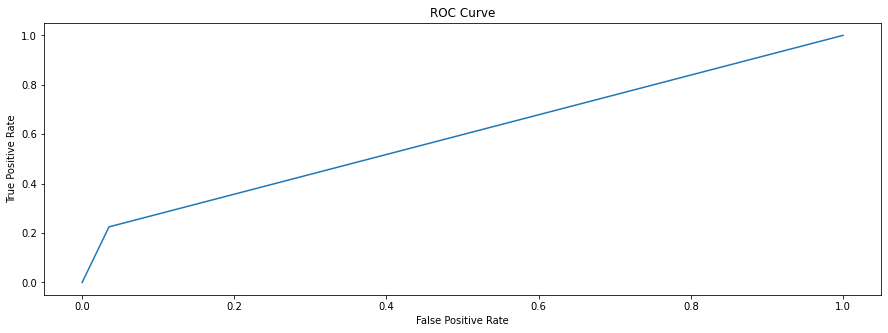

In [335]:
plot_Roc_Curve(gs_TFIDF,X_test['CleanWordList'],y_test)

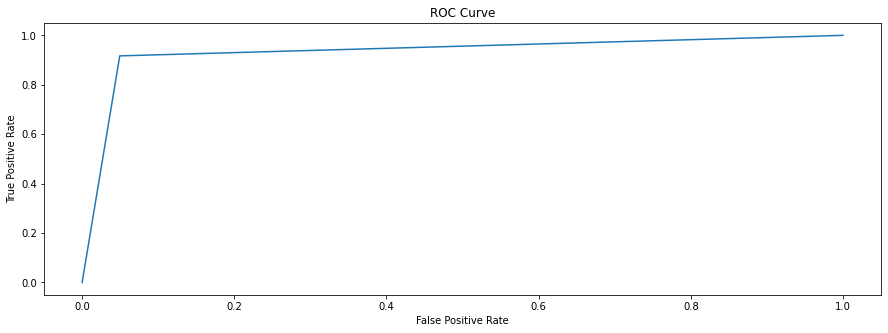

In [336]:
plot_Roc_Curve(gs_CV,X_test['CleanWordList'],y_test)

In [208]:
cm=confusion_matrix(y_test,gs.predict(X_test_all))
cm

array([[274,   9],
       [ 27, 262]], dtype=int64)

In [201]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Greens):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion Matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.grid(False)

# # import itertools
# # plot_confusion_matrix(gs,classes=['Spam','Ham'], normalize=False,
# #                           title='Confusion matrix')